In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import torch
from pathlib import Path
from hython.utils import write_to_zarr, build_mask_dataarray
import matplotlib.pyplot as plt
from pathlib import Path
from hython.datasets.datasets import get_dataset
from numcodecs import Blosc

from torch.utils.data import Dataset, DataLoader

In [9]:
from hython.trainer import XBatcherTrainer
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer

import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

In [10]:
#from torchvision.datasets import MovingMNIST

In [11]:
dir_surr_input = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")


static = xr.open_dataset(dir_surr_input / "staticmaps.nc")#.chunk("auto")
dynamic = xr.open_dataset(dir_surr_input/ "forcings.nc")#.chunk("auto") # C T W H => N T C H W
target = xr.open_dataset(dir_surr_input / "run_default/output.nc").sel(layer=1).isel(lat=slice(None, None, -1))#.chunk("auto") # C T W H => N T C H W


surr_model_output = "convlstm.pt"
experiment = "exp1" # experiment name

dir_surr_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"

SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

mask_from_static = ["wflow_lakeareas"]
rename_mask = ["mask_lake"]


dataset = "XBatchDataset"


# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
KERNEL_SIZE = (3, 3)
NUM_LSTM_LAYER = 2
OUTPUT_SIZE = len(target_names)


TARGET_WEIGHTS = {t:0.5 for t in target_names}



# train/test parameters
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2016-01-01", "2018-12-31")

EPOCHS = 90
BATCH = 64
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 360


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])


In [12]:
wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")

In [13]:
try:
    dynamic = dynamic.rename({"latitude":"lat", "longitude":"lon"})
    static = static.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

In [14]:
# masking 

mask_missing = np.isnan(static[static_names[0]]).rename("mask_missing")

masks = []
masks.append(mask_missing)

for i, mask in enumerate(mask_from_static):
    masks.append((static[mask] > 0).astype(np.bool_).rename(rename_mask[i]))

masks = build_mask_dataarray(masks, names = ["mask_missing"]+ rename_mask).any(dim="mask_layer")

In [15]:
# filter 
dynamic = dynamic[dynamic_names]
target = target[target_names]
static = static.drop_dims("time").sel(layer=1)[ static_names ] 

In [16]:
dynamic = dynamic.to_array() # C T H W
static = static.to_array() # C T H W
target = target.to_array()

In [17]:
target.shape, static.shape, dynamic.shape, masks.shape

((2, 2191, 180, 223), (6, 180, 223), (3, 2192, 180, 223), (180, 223))

In [18]:
dynamic = dynamic.where(~masks, 0)

In [19]:
static = static.where(~masks, 0)

In [20]:
target = target.where(~masks, 0)

In [22]:
# axis=(1,2,3)
# stats = np.nanmean(target,axis=(1,2,3)), np.nanstd(target, axis=(1,2,3)) 
# stats

# (target - np.expand_dims(stats[0], axis=axis)) / (np.expand_dims(stats[1], axis=axis)  - np.expand_dims(stats[0], axis=axis))

In [23]:
# normalize

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", shape="2D")

normalizer_static = Normalizer(method="standardize", type="space", shape="2D")

normalizer_target = Normalizer(method="standardize", type="spacetime", shape="2D")

normalizer_dynamic.compute_stats(dynamic)
normalizer_static.compute_stats(static)
normalizer_target.compute_stats(target)

# TODO: save stats, implement caching of stats to save computation

dynamic = normalizer_dynamic.normalize(dynamic)
static = normalizer_static.normalize(static)
target = normalizer_target.normalize(target)

#Xd_test = normalizer_dynamic.normalize(Xd_test)
#Y_test = normalizer_target.normalize(Y_test)

compute stats
compute stats
compute stats


In [24]:
# expand static to dynamic 

time_da = xr.DataArray(dynamic.time.values, [('time', dynamic.time.values)])
static = static.expand_dims({"time":time_da})

In [25]:
# compressor = Blosc(cname='zl4', clevel=9, shuffle=Blosc.BITSHUFFLE)

# ss = params.drop_dims("time")[[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"]].expand_dims({"time": ds.time}).chunk({"time":500, "latitude":50, "longitude":50})

# ss.to_zarr(wd / "test.zarr",storage_options={"compressor":compressor})

# ss = xr.open_dataset( wd / "test.zarr", engine = "zarr")

# time, lat, lon = 365, 16, 16 

In [26]:
static.shape, static.dims

((2192, 6, 180, 223), ('time', 'variable', 'lat', 'lon'))

In [27]:
target.shape, target.dims

((2, 2191, 180, 223), ('variable', 'time', 'lat', 'lon'))

In [28]:
dynamic.shape, dynamic.dims

((3, 2192, 180, 223), ('variable', 'time', 'lat', 'lon'))

In [29]:
time, lat ,lon = 360, 32,32

In [30]:
train_dataset = get_dataset("XBatchDataset")(
                      dynamic, 
                      target, 
                      static, 
                      lstm=False, 
                      xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
                                       "batch_dims": {"lat":lat, "lon":lon}, 
                                       #"input_overlap":{"time":1},
                                       "concat_input_dims":False,
                                       "preload_batch":True})
test_dataset = get_dataset("XBatchDataset")(
                      dynamic, 
                      target, 
                      static, 
                      lstm=False, 
                      xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
                                       "batch_dims": {"lat":lat, "lon":lon}, 
                                       #"input_overlap":{"time":1},
                                       "concat_input_dims":False,
                                       "preload_batch":True})

dynamic:  180
static:  180
dynamic:  180
static:  180


/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/xbatcher/generators.py:114: UserWarning: The following dimensions were included in both ``input_dims`` and ``batch_dims``. Since ``concat_input_dims`` is ``False``, these dimensions will not impact batch generation: {'lat': 32, 'lon': 32}
  warnings.warn(


In [31]:
dataloader = DataLoader(dataset=train_dataset, batch_size=16)

In [32]:
len(dataloader)

12

In [33]:
res = next(iter(dataloader))

In [34]:
res[0].shape

torch.Size([16, 360, 3, 32, 32])

In [35]:
from hython.models.convLSTM import ConvLSTM

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
model = ConvLSTM(
    input_dim =  DYNAMIC_INPUT_SIZE + STATIC_INPUT_SIZE,
    output_dim= OUTPUT_SIZE,
    hidden_dim = (HIDDEN_SIZE),
    kernel_size = KERNEL_SIZE,
    num_layers = NUM_LSTM_LAYER,
    batch_first = True,
    bias = True,
    return_all_layers = False
).to(device)

In [38]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight={"vwc":0.5, "actevap":0.5})
metric_fn = MSEMetric(target_names=["vwc", "actevap"])

In [39]:
trainer = XBatcherTrainer(
    RNNTrainParams(
               experiment=experiment, 
               temporal_subsampling=False, 
               temporal_subset=1, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [40]:
file_surr_output = f"{dir_surr_output}/{experiment}_{surr_model_output}"

In [ ]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    dataloader,
    dataloader,
    EPOCHS,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
)

  1%|█                                                                                                | 1/90 [00:33<49:38, 33.46s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5765542984008789
val loss: 0.5323127508163452


  2%|██▏                                                                                              | 2/90 [01:05<47:45, 32.57s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5521553158760071
val loss: 0.5298378467559814


  3%|███▏                                                                                             | 3/90 [01:37<46:47, 32.28s/it]

train loss: 0.5271358489990234
val loss: 0.5299137830734253


  4%|████▎                                                                                            | 4/90 [02:09<45:58, 32.07s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5312707424163818
val loss: 0.5261126160621643


  6%|█████▍                                                                                           | 5/90 [02:41<45:31, 32.13s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5284962058067322
val loss: 0.5255627632141113


  7%|██████▍                                                                                          | 6/90 [03:13<45:08, 32.24s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5271654725074768
val loss: 0.5250462293624878


  8%|███████▌                                                                                         | 7/90 [03:43<43:23, 31.37s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5268950462341309
val loss: 0.5240625143051147


  9%|████████▌                                                                                        | 8/90 [04:14<42:47, 31.31s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5260944366455078
val loss: 0.5232425928115845


 10%|█████████▋                                                                                       | 9/90 [04:46<42:29, 31.47s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5251492261886597
val loss: 0.5221048593521118


 11%|██████████▋                                                                                     | 10/90 [05:18<42:03, 31.55s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5240989923477173
val loss: 0.5210644006729126


 12%|███████████▋                                                                                    | 11/90 [05:49<41:39, 31.64s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt
Copied best model weights!
train loss: 0.5233604907989502
val loss: 0.5197805166244507


In [ ]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('SM')
axs[0].set_ylabel(metric_fn.__class__.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
axs[1].set_title('ET')
axs[1].set_ylabel(metric_fn.__class__.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[2].set_title('Loss')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [ ]:
def predict(Xd, Xs, model, batch_size, device):
    model = model.to(device)
    X = torch.concat([Xd, Xs], 2).to(device)
    arr = []
    for i in range(0, Xd.shape[0], batch_size):
        out = model(X)[0]
        #import pdb;pdb.set_trace()
        arr.append(out[i : (i + batch_size)].detach().cpu().numpy())
    return np.vstack(arr)

In [301]:
output = predict(res[0], res[1], model, batch_size=8,device=device)

In [302]:
import matplotlib.pyplot as plt

In [303]:
output.shape

(1, 360, 64, 64, 2)

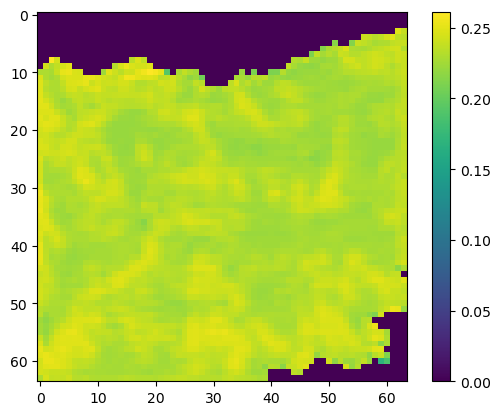

In [305]:
plt.imshow(output[0,-1,:,:,0])
plt.colorbar()

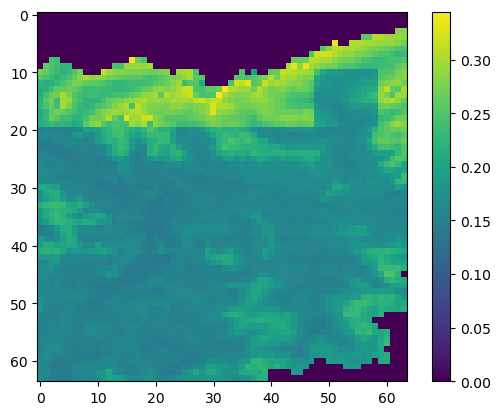

In [307]:
plt.imshow(res[2][0,-1,0,:,:])
plt.colorbar()

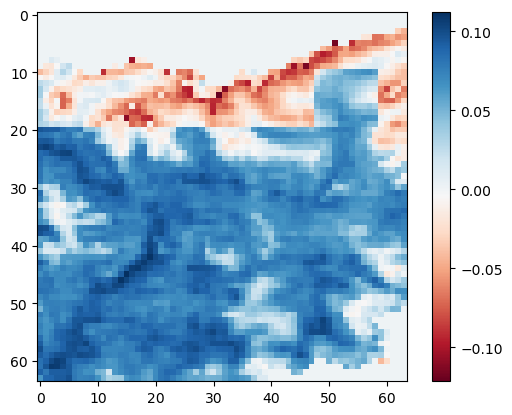

In [313]:
plt.imshow((output[0,-1,:,:,0] - np.array(res[2][0,-1,0,:,:])), cmap="RdBu")
plt.colorbar()

In [ ]:
torch

In [ ]:
torch.split?